# New Notebook : OLS and Lasso

In [28]:
import numpy as np
import pandas as pd
import pprint
import matplotlib
import matplotlib.pyplot as plt        
import sys

sys.path.append('../scripts/')
from models import BaseModels, DataCleaner, ModelPlots, DataModel

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")
counts = pd.read_pickle('../data/monthsCount__0.pckl')
data_cleaner = DataCleaner(speeds, segmentsMeta, mergeResults, counts)
speedDF = data_cleaner.data
countDF = data_cleaner.counts
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67

data_model = DataModel(speedDF, 1, output_lag, sequence_length, valid_split = valid_split, scale_max = False, shift_mean=False)
data_model.preprocessData()
X_train, y_train, X_test, y_test = data_model.trainSplit()

## Normalization

Goal: Z(i) = Z(i) - 1/n Somme sur j  Z(j)

In [198]:
Z = []

for i in range(int((speedDF.shape[1])/20)):
    Z.append(speedDF.iloc[:,i*20:(i+1)*20].values)

print("Z Created!")
n = len(Z)
print("n =", n)

Z = np.array(Z)

Z_train = Z[:44]
Z_test = Z[44:]

M = (1/44)*Z_train.sum(axis=0)

for i in range(44):
    Z_train[i] = Z_train[i] - M
for i in range(65-44):
    Z_test[i] = Z_test[i] - M
    
print("Z Normalized !")

Z Created!
n = 65
Z Normalized !


In [200]:
Z_train[:,1,3].mean()

-2.4223047810003414e-16

In [204]:
def X_Y(Z):
    new_X = Z[:,:,:-1]
    new_Y = Z[:,:,1:]
    new_X = np.concatenate(new_X, axis=1)
    new_Y = np.concatenate(new_Y, axis=1)
    return new_X.T, new_Y.T

def concat_train_test(Z):
    Z_concat = np.concatenate(Z, axis=1)
    Z_train = Z_concat[:, :int(Z_concat.shape[1]*0.67)].T
    Z_test = Z_concat[:,int(Z_concat.shape[1]*0.67):].T
    return Z_train, Z_test

In [205]:
new_X_train, new_Y_train  = X_Y(Z_train)
print(new_X_train.shape, new_Y_train.shape)
new_X_test, new_Y_test = X_Y(Z_test)
print(new_X_test.shape, new_Y_test.shape)

(836, 556) (836, 556)
(399, 556) (399, 556)


In [151]:
X_train.reshape(X_train.shape[0],-1).shape, y_train.shape

((827, 556), (827, 556))

## OLS

In [31]:
%%time
A = [linear_model.LinearRegression() for i in range(nSegments)]

for i in range(nSegments):
    A[i].fit(X_train.reshape(X_train.shape[0],-1), y_train[:, i])

CPU times: user 3min 24s, sys: 1min 36s, total: 5min
Wall time: 1min 17s


In [56]:
preds = []

for i in range(nSegments):
    preds.append(A[i].predict(X_test.reshape(X_test.shape[0],-1)))

preds = np.array(preds)

In [60]:
print("MSE:", mean_squared_error(preds.T.flatten(), y_test.flatten()))
print("MAE:", mean_absolute_error(preds.T.flatten(), y_test.flatten()))

MSE: 313.8508580721112
MAE: 13.201120910650387


## LASSO

In [67]:
%%time
A_lasso = [linear_model.Lasso(alpha=0.1, max_iter=1000, tol=0.0001) for i in range(nSegments)]

for i in range(nSegments):
    A_lasso[i].fit(X_train.reshape(X_train.shape[0],-1), y_train[:, i])

/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You 

CPU times: user 16min 35s, sys: 1.79 s, total: 16min 36s
Wall time: 16min 42s


/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [70]:
preds_lasso = []

for i in range(nSegments):
    preds_lasso.append(A_lasso[i].predict(X_test.reshape(X_test.shape[0],-1)))

preds_lasso = np.array(preds_lasso)

In [71]:
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), y_test.flatten()))

MSE: 259.9223064427821
MAE: 11.860076778179724


In [74]:
A_lasso[1].intercept_

-0.9318537869947647

## LASSO Reg

In [206]:
%%time
A_lasso = [linear_model.Lasso(alpha=1, fit_intercept=True, max_iter=10000, tol=0.001) for i in range(nSegments)]


for i in range(nSegments):
    A_lasso[i].fit(new_X_train, new_Y_train[:, i])
    print(i,"n iter:", A_lasso[i].n_iter_)

0 n iter: 287
1 n iter: 620
2 n iter: 317
3 n iter: 546
4 n iter: 105
5 n iter: 177
6 n iter: 202
7 n iter: 216
8 n iter: 238
9 n iter: 311
10 n iter: 153
11 n iter: 129
12 n iter: 332
13 n iter: 512
14 n iter: 359
15 n iter: 463
16 n iter: 252
17 n iter: 229
18 n iter: 476
19 n iter: 457
20 n iter: 143
21 n iter: 222
22 n iter: 184
23 n iter: 339
24 n iter: 301
25 n iter: 273
26 n iter: 121
27 n iter: 153
28 n iter: 330
29 n iter: 139
30 n iter: 361
31 n iter: 314
32 n iter: 809
33 n iter: 365
34 n iter: 570
35 n iter: 525
36 n iter: 548
37 n iter: 129
38 n iter: 405
39 n iter: 277
40 n iter: 331
41 n iter: 287
42 n iter: 295
43 n iter: 137
44 n iter: 159
45 n iter: 116
46 n iter: 106
47 n iter: 128
48 n iter: 135
49 n iter: 406
50 n iter: 473
51 n iter: 477
52 n iter: 226
53 n iter: 596
54 n iter: 72
55 n iter: 106
56 n iter: 179
57 n iter: 107
58 n iter: 113
59 n iter: 269
60 n iter: 231
61 n iter: 104
62 n iter: 305
63 n iter: 220
64 n iter: 413
65 n iter: 269
66 n iter: 267
67 n i

In [208]:
preds_lasso = []

for i in range(nSegments):
    preds_lasso.append(A_lasso[i].predict(new_X_test))

preds_lasso = np.array(preds_lasso)

In [211]:
print("Avec alpha=1, fit_intercept=True après correction du centrage")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec alpha=1, fit_intercept=True après correction du centrage
MSE: 142.969412057502
MAE: 8.475153833089037


In [180]:
print("Avec alpha=0.1, fit_intercept=False")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec alpha=0.1, fit_intercept=False
MSE: 241.13136917908287
MAE: 11.439466787962637


In [176]:
print("Avec fit_intercept=False")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec fit_intercept=False
MSE: 133.78932257375675
MAE: 8.19079169877789


In [172]:
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

MSE: 135.6287832132292
MAE: 8.25285350689227


In [210]:
np.array([k.intercept_ for k in A_lasso]).mean()

-1.246857901707807e-16

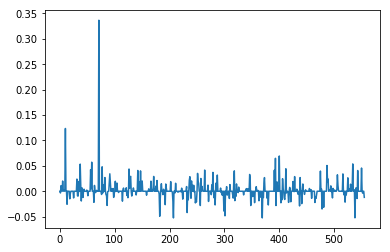

In [189]:
plt.plot(A_lasso[10].coef_)

# LassoCV

In [ ]:
%%time
A_lasso = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001) for i in range(nSegments)]


for i in range(nSegments):
    A_lasso[i].fit(new_X_train, new_Y_train[:, i])
    print(i,"alpha:",A_lasso[i].alpha_,"\nalphas", A_lasso[i].alphas_, "\nnb iter:", A_lasso[i].n_iter_)

0 alpha: 19.559602151828933 
alphas [19.55960215 18.24135043 17.01194446 15.86539634 14.79612173 13.79891265
 12.86891212 12.00159051 11.19272348 10.43837138  9.73486008  9.07876309
  8.46688485  7.89624515  7.36406465  6.86775134  6.40488789  5.97321988
  5.57064485  5.19520203  4.8450628   4.51852179  4.21398854  3.92997982
  3.66511233  3.41809603  3.18772779  2.97288561  2.77252307  2.58566429
  2.41139917  2.24887894  2.09731203  1.95596022  1.82413504  1.70119445
  1.58653963  1.47961217  1.37989126  1.28689121  1.20015905  1.11927235
  1.04383714  0.97348601  0.90787631  0.84668848  0.78962451  0.73640647
  0.68677513  0.64048879  0.59732199  0.55706449  0.5195202   0.48450628
  0.45185218  0.42139885  0.39299798  0.36651123  0.3418096   0.31877278
  0.29728856  0.27725231  0.25856643  0.24113992  0.22488789  0.2097312
  0.19559602  0.1824135   0.17011944  0.15865396  0.14796122  0.13798913
  0.12868912  0.12001591  0.11192723  0.10438371  0.0973486   0.09078763
  0.08466885  0.